<Figure size 720x576 with 0 Axes>

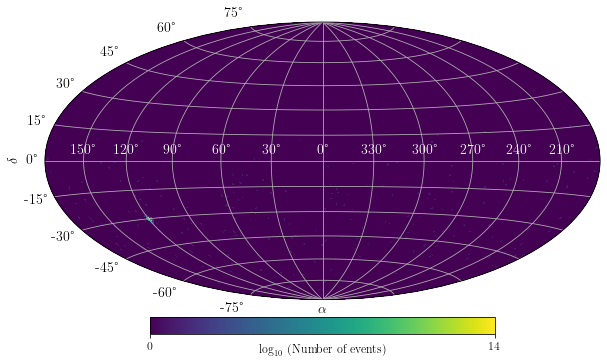

In [9]:
#---------------------------------------
# Try optimize the code!!!!
#---------------------------------------
import math
import numpy as np 
import healpy as hp
from healpy.newvisufunc import projview

#for plotting 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import rc

#to import and work with data frames 
import pandas as pd

%matplotlib inline

rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=True)

#convert a set of pandas columns into a list of event 
def pandas_to_event(df, str1 , str2, str3, str4, str5):
    
    alpha = df[str1].to_numpy()
    delta = df[str2].to_numpy()
    time = df[str3].to_numpy()
    energy = df[str4].to_numpy()
    tau = df[str5].to_numpy()
    
    evt_list = []
    
    for i in range(len(alpha)):
        evt_list.append([alpha[i],delta[i],time[i],energy[i],tau[i]])
        
    return evt_list

#convert to healpy coordinates 
def Healpy_Event(evt_list):
        
    new_evt_list = []
    
    for evt in evt_list:
        evt[1] = math.pi/2 - evt[1]
        new_evt_list.append(evt)
    
        
    return new_evt_list

#-------------------------------
# main 
#-------------------------------

#save dataframe with event info from parquet file
path_to_repeater_file = '/home/miguelm/Documents/Anisotropies/DataSets/MockData_Repeaters/'
repeater_file = 'Rep_events_with_tau_Date_2015-01-01T00:00:00_Period_3600_TotalEvents_100000_AcceptedRepEvents_100.parquet'

repeater_data = pd.read_parquet(path_to_repeater_file + repeater_file, engine='fastparquet') 

#convert dataframe into a list of events
repeater_evt_list = pandas_to_event(repeater_data,"evt1_ra (rad)", "evt1_dec (rad)","evt1_gpstime","evt1_energy (EeV)", "tau (s)")    
repeater_evt_late_list = pandas_to_event(repeater_data,"evt2_ra (rad)", "evt2_dec (rad)","evt2_gpstime","evt2_energy (EeV)", "tau (s)")

#change delta into colatitude to project in sky
hp_repeater_evt = Healpy_Event(repeater_evt_list)
hp_repeater_late_evt = Healpy_Event(repeater_evt_late_list)

#12*nside*nside gives the number of pixels of sphere 
NSIDE = 64
            
#vector with index positions in healpy sky_map given theta and phi
cr_sky_indexes = [] 

#vector to hold events. If the event is accepted, the vector is field with 1, otherwise it is filed with 0
events = []

#define tau threshold in seconds since 1 sidereal day has 86164 seconds
tau_th = 86164

#run over the events 
for evt in hp_repeater_evt:
    
    cr_sky_indexes.append(hp.ang2pix(NSIDE,evt[1],evt[0]))
    
    if(evt[4] > tau_th):
        events.append(0)
    
    else:
        events.append(1)
        
#print(cr_sky_indexes)

#count map for each event: vector with size npix and filled with 0s
instant_cr_sky = np.zeros(hp.nside2npix(NSIDE))

#subsitutes zeros in the pixel indices for their bin content, given the data
np.add.at(instant_cr_sky, cr_sky_indexes, events)

#save figure
fig = plt.figure(figsize=(10,8)) #create figure

#plot sky map 
projview(
    instant_cr_sky,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit=r"$\log_{10}$ (Number of events)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white',
)

plt.savefig('Repeater_Doublets.pdf')

#print(type(var))

In [152]:
#-------------------------------------------------------
# Compute the time diference between consecutive events in the same angular window in the celestial sky
#-------------------------------------------------------

#to order events according to their time stamp
def TimeOrderedEvents(event_list):
    
    alpha, delta, t = [], [], []
    
    for evt in event_list:
        alpha.append(evt.alpha)
        delta.append(evt.delta)
        t.append(evt.t)
    
    alpha = np.array(alpha)
    delta = np.array(delta)
    t = np.array(t)
    
    alpha_time_ordered = alpha[t.argsort()]
    delta_time_ordered = delta[t.argsort()]
    t_ordered = sorted(t)
    
    ordered_event_list = []
    
    for i in range(len(t)):
        ordered_event_list.append(Event(alpha_time_ordered[i],delta_time_ordered[i],t_ordered[i]))
    
    return ordered_event_list

#Returns true if event is in a cap around first event and false otherwise
def EventInSphericalCap(alpha_center, delta_center, alpha, delta, ang_window):
    
    pos_center = hp.ang2vec(math.pi/2 - delta_center, alpha_center)
    pos = hp.ang2vec(math.pi/2 - delta, alpha)
    
    ang_sep = math.acos(np.dot(pos_center,pos))
    
    if( ang_sep > ang_window ):
        return False
    else:
        return True


#angular window
ang_window = np.radians(30)

#set begin time 
task2_begin = datetime.now()

#time order accepted events 
time_ordered_accepted_events = TimeOrderedEvents(accepted_events_list)

#vector with time interval between consecutive events
tau = []

#compute the time difference between two consecutive events        
for evt1 in time_ordered_accepted_events:
    
    for evt2 in time_ordered_accepted_events:
        
        if evt2 > evt1:
            
            if ( abs(evt1.delta - evt2.delta) > ang_window or abs(evt1.alpha - evt2.alpha) > ang_window ):
                continue
            
            if EventInSphericalCap(evt1.alpha, evt1.delta, evt2.alpha, evt2.delta, ang_window):
                tau.append(evt2.t.unix - evt1.t.unix)
                break
        
print('The computation for tau for', N_events, 'events took', datetime.now() - task2_begin)

The computation for tau for 100000 events took 0:46:09.200997


Average tau = 2.6904135258438955 days


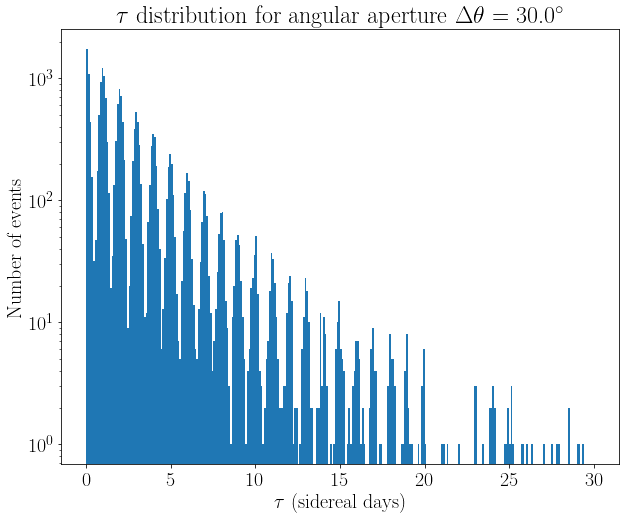

In [168]:
#-----------------------------------------------------
# Draw the tau distribution
#-----------------------------------------------------

#tau_log = []
tau_days = np.multiply(tau,1/86164)

#for t in tau:
    
    #if( t < 3600):
        #print(t)
print('Average tau =',sum(tau_days)/len(tau_days),'days')

#for dt in tau_days:
        #tau_log.append(math.log10(dt))
        
fig_tau = plt.figure(figsize=(10,8)) #create figure
ax_tau = fig_tau.add_subplot(111) #create subplot with a set of axis with 

ax_tau.hist(tau_days,bins=300, range=[0,30])
ax_tau.set_title(r'$\tau$ distribution for angular aperture $\Delta \theta =$ ' + str(round(np.degrees(ang_window),2)) + '$^{\circ}$',fontsize=24)
ax_tau.set_xlabel(r'$\tau$ (sidereal days)', fontsize=20)
ax_tau.set_ylabel(r'Number of events', fontsize=20)
ax_tau.tick_params(axis='both', which='major', labelsize=20)
ax_tau.set_yscale('log')